---> Mutational Signatures Analysis <---
[SPA] Fitting WES
[SPA] Fitting WGS
[SPA] Fitting TSO-500
--> Figure 2A (display)


/var/folders/gy/zbl8pg897s563qk00bnksvl00000gn/T/ipykernel_42055/926381917.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, vert=False, labels=order)


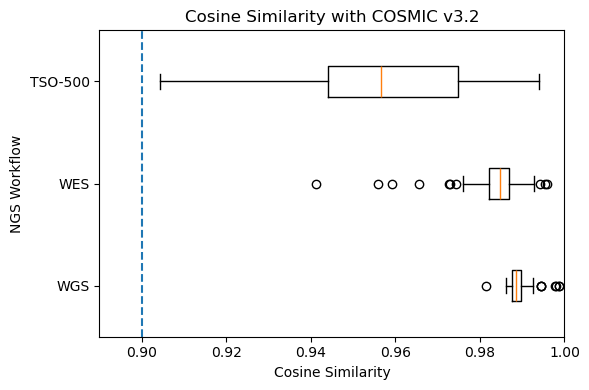

[Saved] Musical_signature_results/v3.2/cosine_boxplot.png


In [3]:
#!/usr/bin/env python3
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import musical  # https://github.com/parklab/MuSiCal


# -------------------- Config --------------------
BASE_DIR   = os.getcwd()
COSMIC_DIR = "Cosmic files"
INPUT_DIR  = "Input files"
OUT_DIR    = "Musical_signature_results/v3.2"
COSMIC_FILE = "COSMIC_v3.2_SBS_GRCh38.txt"  # contexts x signatures (tab-separated)

FILE_MAP = {
    "WES":     "Preclinical_Dataset_WES.txt",      # contexts x samples (tab-separated)
    "WGS":     "Preclinical_Dataset_WGS.txt",
    "TSO-500": "Preclinical_Dataset_TSO-500.txt",
}


# -------------------- IO helpers --------------------
def load_cosmic_signatures(cosmic_file, cosmic_dir=COSMIC_DIR, base_dir=BASE_DIR):
    path = os.path.join(base_dir, cosmic_dir, cosmic_file)
    # rows: contexts, cols: signatures
    df = pd.read_csv(path, sep="\t", index_col=0)
    return df

def load_crc_data(dataset_type, input_dir=INPUT_DIR, base_dir=BASE_DIR):
    path = os.path.join(base_dir, input_dir, FILE_MAP[dataset_type])
    # rows: contexts, cols: samples
    df = pd.read_csv(path, sep="\t", index_col=0)
    return df


# -------------------- Math helpers --------------------
def normalize_contributions(contrib):
    # contrib: signatures x samples
    colsum = contrib.sum(axis=0)
    colsum[colsum == 0] = 1.0
    return contrib / colsum

def cosine_per_sample(reconstructed, observed):
    # both: contexts x samples, same columns
    X = reconstructed.values
    Y = observed.loc[reconstructed.index, reconstructed.columns].values
    # L2-normalize columns, then column-wise dot
    def l2c(a): 
        n = np.linalg.norm(a, axis=0)
        n[n == 0] = 1.0
        return a / n
    Xn, Yn = l2c(X), l2c(Y)
    return np.einsum("ij,ij->j", Xn, Yn)


# -------------------- Core: MuSiCal fit --------------------

def fit_with_MuSiCal(
    samples_df,
    signature_db_path,
    outdir=OUT_DIR,
    method="likelihood_bidirectional",
    thresh=0.001,
    relevant_sigs_path=None,          # optional: TSV/CSV with a header row; uses column names
    mutpatterns_index_path=None       # optional: a one-column file giving desired context order
):
    """
    MuSiCal refit to get signature contributions.

    samples_df: DataFrame, rows=contexts, cols=samples
    signature_db_path: path to COSMIC matrix (rows=contexts, cols=signatures, TSV)
    returns: dict with
        - "contribution": signatures x samples
        - "reconstructed": contexts x samples
    """
    os.makedirs(outdir, exist_ok=True)

    # Load signatures (contexts x signatures)
    W = pd.read_csv(signature_db_path, sep="\t", index_col=0)

    # Optional: match MutationalPatterns context order if provided
    if mutpatterns_index_path is not None:
        mp_index = pd.read_csv(mutpatterns_index_path, header=None).squeeze()
        # Only reindex if all contexts exist; otherwise ignore
        if pd.Index(mp_index).isin(W.index).all():
            W = W.reindex(mp_index)

    # Optional: limit to a set of relevant signatures if provided
    if relevant_sigs_path is not None:
        rel = pd.read_csv(relevant_sigs_path)
        cols = [c for c in rel.columns if c in W.columns]
        if cols:
            W = W[cols]

    # Align contexts between catalogues (X) and signature profiles (W)
    common_ctx = samples_df.index.intersection(W.index)
    if len(common_ctx) == 0:
        raise ValueError("No overlapping mutation contexts between samples and signature database.")
    X = samples_df.loc[common_ctx]
    W = W.loc[common_ctx]

    # Run MuSiCal sparse refit
    H, model = musical.refit.refit(X, W, method=method, thresh=thresh)  # H: signatures x samples

    # Ensure DataFrame with consistent axes
    if not isinstance(H, pd.DataFrame):
        H = pd.DataFrame(H, index=W.columns, columns=X.columns)
    else:
        # Reorder to strict (signatures x samples)
        H = H.reindex(index=W.columns, columns=X.columns)

    # Reconstruct catalogues: (contexts x signatures) @ (signatures x samples)
    reconstructed = W.values @ H.values
    reconstructed = pd.DataFrame(reconstructed, index=common_ctx, columns=H.columns)

    # (Optional) write contributions like in your template
    H.to_csv(os.path.join(outdir, "MuSiCal-contribution.dat"))

    return {
        "contribution": H,            # signatures x samples
        "reconstructed": reconstructed  # contexts x samples
    }



# -------------------- Plot --------------------
def plot_cosine_box(cosine_df, title="Cosine Similarity with COSMIC v3.2",
                    out_png=os.path.join(OUT_DIR, "cosine_boxplot.png")):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6, 4))
    order = ["WGS", "WES", "TSO-500"]
    data = [cosine_df.loc[cosine_df["Data_Type"] == k, "Cosine_Similarity"].values for k in order]
    ax.boxplot(data, vert=False, labels=order)
    ax.set_xlabel("Cosine Similarity")
    ax.set_ylabel("NGS Workflow")
    ax.set_title(title)
    ax.set_xlim(0.89, 1.0)           # optional
    ax.axvline(0.90, linestyle="--") # optional
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    try:
        plt.show()  # does nothing on headless runs; OK
    except Exception:
        pass
    print(f"[Saved] {out_png}")


# -------------------- Orchestration --------------------
def main():
    print("---> Mutational Signatures Analysis <---")

    # Paths
    signature_db_path = os.path.join(BASE_DIR, COSMIC_DIR, COSMIC_FILE)

    # Load data
    cosmic_df = load_cosmic_signatures(COSMIC_FILE)  # not directly used in SPA; kept for parity
    CRC_WES = load_crc_data("WES")
    CRC_WGS = load_crc_data("WGS")
    CRC_TSO = load_crc_data("TSO-500")

    # Fit each dataset with SPA
    print("[SPA] Fitting WES")
    wes_fit = fit_with_MuSiCal(CRC_WES, signature_db_path=signature_db_path, outdir=os.path.join(OUT_DIR, "WES"))
    print("[SPA] Fitting WGS")
    wgs_fit = fit_with_MuSiCal(CRC_WGS, signature_db_path=signature_db_path, outdir=os.path.join(OUT_DIR, "WGS"))
    print("[SPA] Fitting TSO-500")
    tso_fit = fit_with_MuSiCal(CRC_TSO, signature_db_path=signature_db_path, outdir=os.path.join(OUT_DIR, "TSO-500"))

    # Normalise contributions
    wes_contrib_norm = normalize_contributions(wes_fit["contribution"])
    wgs_contrib_norm = normalize_contributions(wgs_fit["contribution"])
    tso_contrib_norm = normalize_contributions(tso_fit["contribution"])

    # Compute cosine similarities (per sample)
    wes_cos = cosine_per_sample(wes_fit["reconstructed"], CRC_WES)
    wgs_cos = cosine_per_sample(wgs_fit["reconstructed"], CRC_WGS)
    tso_cos = cosine_per_sample(tso_fit["reconstructed"], CRC_TSO)

    # Collect for plotting
    cosine_df = pd.DataFrame({
        "Cosine_Similarity": np.concatenate([wgs_cos, wes_cos, tso_cos]),
        "Data_Type": (["WGS"] * len(wgs_cos)) + (["WES"] * len(wes_cos)) + (["TSO-500"] * len(tso_cos))
    })

    print("--> Figure 2A (display)")
    plot_cosine_box(cosine_df)

if __name__ == "__main__":
    main()


In [ ]:
#cosine_to_tsv
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import musical  # pip install MuSiCal

# -------------------- Config --------------------
BASE_DIR   = os.getcwd()
COSMIC_DIR = "Cosmic files"
INPUT_DIR  = "Input files"
OUT_BASE   = "Musical_signature_results"

COSMIC_FILES = [
    "COSMIC_v2_SBS_GRCh38.txt",
    "COSMIC_v3.2_SBS_GRCh38.txt",
]

FILE_MAP = {
    "WES":     "Preclinical_Dataset_WES.txt",
    "WGS":     "Preclinical_Dataset_WGS.txt",
    "TSO-500": "Preclinical_Dataset_TSO-500.txt",
}

TOOL_NAME = "MuSiCal"


# -------------------- IO helpers --------------------
def load_crc_data(dataset_type, input_dir=INPUT_DIR, base_dir=BASE_DIR):
    path = os.path.join(base_dir, input_dir, FILE_MAP[dataset_type])
    df = pd.read_csv(path, sep="\t", index_col=0)  # rows=contexts, cols=samples
    return df

def load_cosmic_signatures(cosmic_file, cosmic_dir=COSMIC_DIR, base_dir=BASE_DIR):
    path = os.path.join(base_dir, cosmic_dir, cosmic_file)
    df = pd.read_csv(path, sep="\t", index_col=0)  # rows=contexts, cols=signatures
    return df


# -------------------- Math helpers --------------------
def cosine_per_sample(reconstructed: pd.DataFrame, observed: pd.DataFrame) -> pd.Series:
    """
    Return per-sample cosine similarity as a pandas Series indexed by sample name.
    """
    common_ctx = reconstructed.index.intersection(observed.index)
    common_samples = reconstructed.columns.intersection(observed.columns)
    X = reconstructed.loc[common_ctx, common_samples].values
    Y = observed.loc[common_ctx, common_samples].values

    def l2c(a):
        n = np.linalg.norm(a, axis=0)
        n[n == 0] = 1.0
        return a / n

    Xn, Yn = l2c(X), l2c(Y)
    cos = np.einsum("ij,ij->j", Xn, Yn)
    return pd.Series(cos, index=common_samples)


# -------------------- MuSiCal wrapper --------------------
def fit_with_MuSiCal(samples_df: pd.DataFrame,
                     signature_df: pd.DataFrame,
                     method: str = "likelihood_bidirectional",
                     thresh: float = 0.001):
    """
    samples_df: contexts x samples
    signature_df: contexts x signatures
    returns contribution (signatures x samples), reconstructed (contexts x samples)
    """
    # Align contexts
    common_ctx = samples_df.index.intersection(signature_df.index)
    if len(common_ctx) == 0:
        raise ValueError("No overlapping contexts between samples and signatures.")
    X = samples_df.loc[common_ctx]
    W = signature_df.loc[common_ctx]

    # Run MuSiCal refit
    H, model = musical.refit.refit(X, W, method=method, thresh=thresh)

    # Coerce to DataFrame: signatures x samples
    if not isinstance(H, pd.DataFrame):
        H = pd.DataFrame(H, index=W.columns, columns=X.columns)
    else:
        H = H.reindex(index=W.columns, columns=X.columns)

    # Reconstruct catalogues: (contexts x signatures) @ (signatures x samples)
    reconstructed = W.values @ H.values
    reconstructed = pd.DataFrame(reconstructed, index=common_ctx, columns=H.columns)

    return {
        "contribution": H,
        "reconstructed": reconstructed
    }


# -------------------- Orchestration --------------------
def main():
    all_rows = []

    # Preload catalogues
    CRC = {
        dt: load_crc_data(dt)
        for dt in ["WGS", "WES", "TSO-500"]
    }

    for cosmic_file in COSMIC_FILES:
        cosmic_version = os.path.splitext(cosmic_file)[0]
        sig_df = load_cosmic_signatures(cosmic_file)
        out_version_dir = os.path.join(OUT_BASE, cosmic_version)
        os.makedirs(out_version_dir, exist_ok=True)

        print(f"\n=== {TOOL_NAME} with {cosmic_version} ===")

        for dt in ["WGS", "WES", "TSO-500"]:
            print(f"[{TOOL_NAME}] Fitting {dt}")
            fit = fit_with_MuSiCal(CRC[dt], sig_df)

            cos_series = cosine_per_sample(fit["reconstructed"], CRC[dt])

            # Optional: write contributions if you want
            contrib_out = os.path.join(out_version_dir, f"{dt}_MuSiCal_contribution.tsv")
            fit["contribution"].to_csv(contrib_out, sep="\t")

            for sample, cos_val in cos_series.items():
                all_rows.append({
                    "Sample": sample,
                    "Cosine_Similarity": float(cos_val),
                    "Data_Type": dt,
                    "Tool": TOOL_NAME,
                    "COSMIC_Version": cosmic_version,
                })

    df_all = pd.DataFrame(all_rows)
    out_tsv = "CosineResults_MuSiCal_ALL.tsv"
    df_all.to_csv(out_tsv, sep="\t", index=False)
    print(f"\n[Saved] {out_tsv}")
    print(df_all.head())


if __name__ == "__main__":
    main()


In [1]:
#!/usr/bin/env python3
# musical_save_all.py
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
import musical  # pip install MuSiCal

# -------------------- Config --------------------
BASE_DIR   = os.getcwd()
COSMIC_DIR = "Cosmic files"
INPUT_DIR  = "Input files"
OUT_BASE   = "signature_results/Musical"
TOOL_NAME  = "MuSiCal"

COSMIC_FILES = [
    "COSMIC_v2_SBS_GRCh38.txt",
    "COSMIC_v3.2_SBS_GRCh38.txt",
]

FILE_MAP = {
    "WES":     "Preclinical_Dataset_WES.txt",
    "WGS":     "Preclinical_Dataset_WGS.txt",
    "TSO-500": "Preclinical_Dataset_TSO-500.txt",
}

# -------------------- Helpers --------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def load_crc_data(dataset_type):
    path = os.path.join(BASE_DIR, INPUT_DIR, FILE_MAP[dataset_type])
    return pd.read_csv(path, sep="\t", index_col=0)  # rows=contexts, cols=samples

def load_cosmic_signatures(cosmic_file):
    path = os.path.join(BASE_DIR, COSMIC_DIR, cosmic_file)
    return pd.read_csv(path, sep="\t", index_col=0)  # rows=contexts, cols=signatures

def normalize_contributions(contrib):
    colsum = contrib.sum(axis=0)
    colsum[colsum == 0] = 1.0
    return contrib / colsum

def cosine_per_sample(reconstructed: pd.DataFrame, observed: pd.DataFrame) -> pd.Series:
    common_ctx = reconstructed.index.intersection(observed.index)
    common_smp = reconstructed.columns.intersection(observed.columns)
    X = reconstructed.loc[common_ctx, common_smp].values
    Y = observed.loc[common_ctx, common_smp].values

    def l2c(a):
        n = np.linalg.norm(a, axis=0)
        n[n == 0] = 1.0
        return a / n

    Xn, Yn = l2c(X), l2c(Y)
    cos = np.einsum("ij,ij->j", Xn, Yn)
    return pd.Series(cos, index=common_smp)

def save_matrix(df: pd.DataFrame, path: str):
    df.to_csv(path, sep="\t")

# -------------------- MuSiCal wrapper --------------------
def fit_with_MuSiCal(samples_df: pd.DataFrame,
                     signature_df: pd.DataFrame,
                     method: str = "likelihood_bidirectional",
                     thresh: float = 0.001):
    # Align contexts
    common_ctx = samples_df.index.intersection(signature_df.index)
    if len(common_ctx) == 0:
        raise ValueError("No overlapping mutation contexts between samples and signatures.")
    X = samples_df.loc[common_ctx]
    W = signature_df.loc[common_ctx]

    # Run MuSiCal refit
    H, model = musical.refit.refit(X, W, method=method, thresh=thresh)  # signatures x samples (DataFrame or np.array)

    if not isinstance(H, pd.DataFrame):
        H = pd.DataFrame(H, index=W.columns, columns=X.columns)
    else:
        # reorder strictly to W columns (signatures) and X columns (samples)
        H = H.reindex(index=W.columns, columns=X.columns)

    reconstructed = W.values @ H.values
    reconstructed = pd.DataFrame(reconstructed, index=common_ctx, columns=H.columns)

    return {"contribution": H, "reconstructed": reconstructed}

# -------------------- Orchestration --------------------
def main():
    CRC = {dt: load_crc_data(dt) for dt in ["WGS", "WES", "TSO-500"]}

    all_rows = []

    for cosmic_file in COSMIC_FILES:
        cosmic_version = os.path.splitext(cosmic_file)[0]
        out_version_dir = os.path.join(OUT_BASE, cosmic_version)
        ensure_dir(out_version_dir)

        sig_df = load_cosmic_signatures(cosmic_file)

        print(f"\n=== {TOOL_NAME} | {cosmic_version} ===")

        for dt in ["WGS", "WES", "TSO-500"]:
            print(f"[{TOOL_NAME}] Fitting {dt}")
            fit = fit_with_MuSiCal(CRC[dt], sig_df)

            contrib = fit["contribution"].copy()                     # signatures x samples
            contrib_norm = normalize_contributions(contrib)
            recon = fit["reconstructed"]                             # contexts x samples

            # Save matrices
            save_matrix(contrib,      os.path.join(out_version_dir, f"{dt}_contribution.tsv"))
            save_matrix(contrib_norm, os.path.join(out_version_dir, f"{dt}_contribution_normalized.tsv"))
            save_matrix(recon,        os.path.join(out_version_dir, f"{dt}_reconstructed.tsv"))

            # Metadata
            pd.DataFrame({"Signature": contrib.index}).to_csv(
                os.path.join(out_version_dir, f"{dt}_signatures_used.tsv"), sep="\t", index=False
            )
            pd.DataFrame({"Context": recon.index}).to_csv(
                os.path.join(out_version_dir, f"{dt}_contexts_used.tsv"), sep="\t", index=False
            )

            # Cosine rows
            cos = cosine_per_sample(recon, CRC[dt])
            for smp, val in cos.items():
                all_rows.append({
                    "Sample": smp,
                    "Cosine_Similarity": float(val),
                    "Data_Type": dt,
                    "Tool": TOOL_NAME,
                    "COSMIC_Version": cosmic_version,
                })

    df_all = pd.DataFrame(all_rows)
    df_all.to_csv("CosineResults_MuSiCal_ALL.tsv", sep="\t", index=False)
    print("\n[Saved] CosineResults_MuSiCal_ALL.tsv")


if __name__ == "__main__":
    main()



=== MuSiCal | COSMIC_v2_SBS_GRCh38 ===
[MuSiCal] Fitting WGS
[MuSiCal] Fitting WES
[MuSiCal] Fitting TSO-500

=== MuSiCal | COSMIC_v3.2_SBS_GRCh38 ===
[MuSiCal] Fitting WGS
[MuSiCal] Fitting WES
[MuSiCal] Fitting TSO-500

[Saved] CosineResults_MuSiCal_ALL.tsv


In [ ]:
#TEST MUSICAL

#!/usr/bin/env python3
import numpy as np
import pandas as pd
import musical

# -------------------------------
# 1. Create dummy COSMIC-like signature matrix (96 contexts × 10 signatures)
# -------------------------------
n_contexts = 96
n_signatures = 10
np.random.seed(42)

contexts = [f"C{i+1}" for i in range(n_contexts)]
signatures = [f"S{i+1}" for i in range(n_signatures)]

W = pd.DataFrame(
    np.abs(np.random.rand(n_contexts, n_signatures)),
    index=contexts,
    columns=signatures
)

# normalise each column to sum to 1 (like real signatures)
W = W.div(W.sum(axis=0), axis=1)

# -------------------------------
# 2. Create dummy sample catalogue (96 contexts × 5 samples)
# -------------------------------
n_samples = 5
samples = [f"Sample_{i+1}" for i in range(n_samples)]

# random linear combination of signatures
H_true = np.abs(np.random.rand(n_signatures, n_samples))
X = W.values @ H_true
X = pd.DataFrame(X, index=contexts, columns=samples)

# -------------------------------
# 3. Run MuSiCal refit
# -------------------------------
print("[MuSiCal] Starting dummy fit...")
H_pred, model = musical.refit.refit(
    X,
    W,
    method="likelihood_bidirectional",  # or "nnls" for speed
    thresh=0.001
)
print("[MuSiCal] Fit finished ✅")

# -------------------------------
# 4. Show results
# -------------------------------
print("Estimated contributions (H):")
print(H_pred.head())
print(f"\nShape of H: {H_pred.shape}")


[MuSiCal] Starting dummy fit...
[MuSiCal] Fit finished ✅
Estimated contributions (H):
    Sample_1  Sample_2  Sample_3  Sample_4  Sample_5
S1  0.000000  0.603152  0.301494  0.474930  0.000000
S2  0.403790  0.719046  0.375560  0.760260  0.480459
S3  0.706937  0.936830  0.761833  0.000000  0.000000
S4  0.318270  0.595078  0.000000  0.647638  0.663477
S5  0.340341  0.770912  0.000000  0.000000  0.782168

Shape of H: (10, 5)
